In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

## load data and train model

In [2]:
with open("train.pkl", "rb") as f:
    df = pickle.load(f)
    
x = df[['x_pos', 'y_pos', 'x_vec', 'y_vec', 'x_vec2', 'y_vec2', 'x_dest', 'y_dest']].to_numpy()
y = df[['x_tar', 'y_tar']].to_numpy()

In [ ]:
# clf = MLPRegressor(verbose=True, hidden_layer_sizes=(50,100,50), max_iter=100).fit(x,y)

In [ ]:
# clf = RandomForestRegressor().fit(x,y)

In [ ]:
# with open('model.pkl', 'wb') as f:
#     pickle.dump(clf, f)

In [3]:
with open('model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [4]:
from simulate import Simulator

In [14]:
tis = np.array([[[1050, 275, 0, 0, 0, 0, 1000, 470]],
        [[580*2, 50*2, 0, 0, 0, 0, 250*2, 280*2]],
        [[200*2, 225*2, 0, 0, 0, 0, 500*2, 250*2]],
        [[125*2, 200*2, 0, 0, 0, 0, 460*2, 50*2]],
        [[580*2, 50*2, 0, 0, 0, 0, 250*2, 300*2]],
        [[150*2, 240*2, 0, 0, 0, 0, 250*2, 300*2]]
        ]).reshape(-1,8)
sim = Simulator(clf, tis)

<AxesSubplot:>

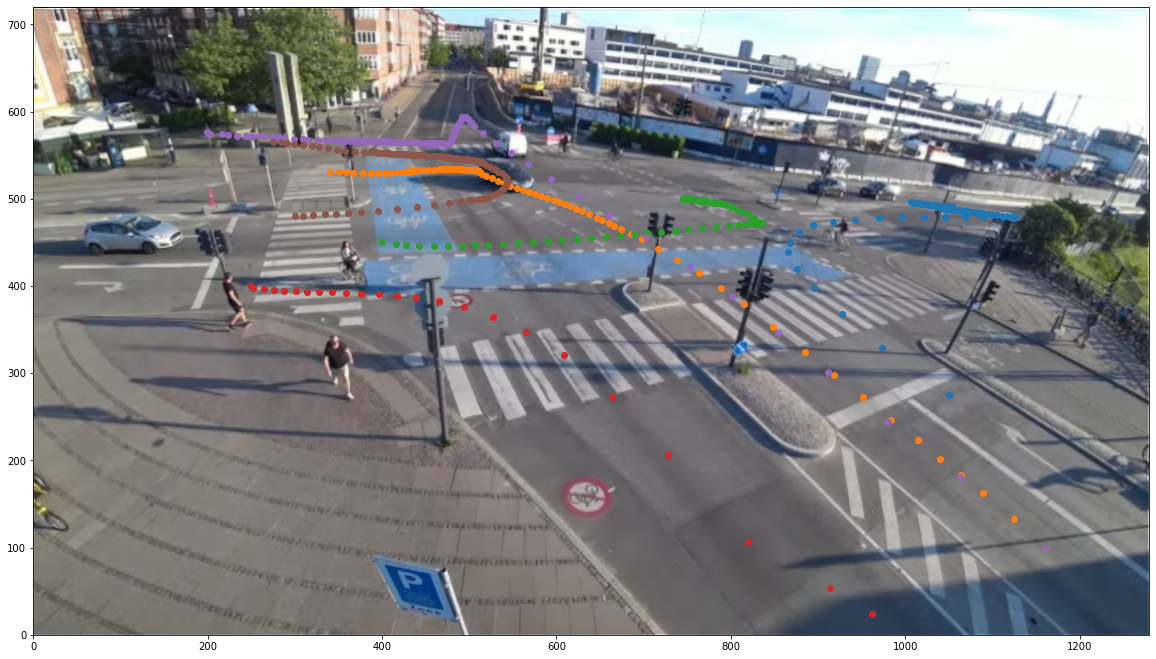

In [15]:
d = sim.simulate()
sim.plot_simulation(d)

## validate model

In [ ]:
with open('val.pkl', 'rb') as f:
    val = pickle.load(f)
x_val = val[['x_pos', 'y_pos', 'x_vec', 'y_vec', 'x_vec2', 'y_vec2', 'x_dest', 'y_dest']].to_numpy()
y_val = val[['x_tar', 'y_tar']].to_numpy()

In [ ]:
clf.score(x_val, y_val)

## simulate trajectories

In [ ]:
def simulate(clf, input, iterations, margin):
    for i in range(iterations):
        if input[i][0] < input[i][4] + margin and input[i][0] > input[i][4] - margin and input[i][1] < input[i][5] + margin and input[i][1] > input[i][5] - margin:
            return np.array(input)
        output = clf.predict([input[i]])
        next = [
            output[0][0]+input[i][0],     # x_pos = x_vec + x_pos_1-
            output[0][1]+input[i][1],     # y_pos
            output[0][0], output[0][1],   # x_prev, y_prev
            input[i][2], input[i][3],     # x_prev_prev
            input[i][-2], input[i][-1]]   # dest
        input.append(next)
    return np.array(input)

In [ ]:
tis = [[[1050, 275, 0, 0, 0, 0, 1000, 470]],
        [[580*2, 50*2, 0, 0, 0, 0, 250*2, 280*2]],
        [[200*2, 225*2, 0, 0, 0, 0, 500*2, 250*2]],
        [[125*2, 200*2, 0, 0, 0, 0, 460*2, 50*2]],
        [[580*2, 50*2, 0, 0, 0, 0, 250*2, 300*2]],
        [[150*2, 240*2, 0, 0, 0, 0, 250*2, 300*2]]]

fig, ax = plt.subplots(figsize=(10,10))
im = Image.open("intersection2.png")
im = ImageOps.flip(im)
ax.set_xlim(0,1280)
ax.set_ylim(0,720)
ax.imshow(im, origin='lower')
for n in tis:
    ax.scatter([n[0][0], n[0][-2]], [n[0][1], n[0][-1]], s=200)

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
im = Image.open("intersection2.png")
im = ImageOps.flip(im)
ax.set_xlim(0,1280)
ax.set_ylim(0,720)
ax.imshow(im, origin='lower')
sims = []
for n in tis:
    sim = simulate(clf, n, 100, 25)
    sims.append(sim)
    ax.plot(sim[:,:1], sim[:,1:2])
    ax.scatter(sim[:,:1], sim[:,1:2])
sims = np.array(sims)

In [ ]:
from sampler import Sampler
s = Sampler()
tis = np.array([[0,0,0,0,0,0]])
for _ in range(5):
    sample = s.get_sample()
    tis = np.concatenate((tis, [np.concatenate((sample[0], [0,0], sample[1]))]))

fig, ax = plt.subplots(figsize=(20,20))
im = Image.open("intersection2.png")
im = ImageOps.flip(im)
ax.set_xlim(0,1280)
ax.set_ylim(0,720)
ax.imshow(im, origin='lower')
sims = []
for n in tis:
    sim = simulate(clf, [n], 100, 25)
    sims.append(sim)
    ax.plot(sim[:,:1], sim[:,1:2])
    ax.scatter(sim[:,:1], sim[:,1:2])
sims = np.array(sims)

## traffic light plotting

In [ ]:
with open('bsc-3m/signals.pickle', 'rb') as f:
    li = pickle.load(f)
    
with open('bsc-3m/signal_lines_true.pickle', 'rb') as f:
    asd = pickle.load(f)

In [ ]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(20,20))
im = Image.open("intersection2.png")
im = ImageOps.flip(im)
ax.set_xlim(0, 1280)
ax.set_ylim(0,720)
ax.imshow(im, origin='lower')

# Create a Rectangle patch
for ind in range(20):
    w = asd[ind]['x'][1] - asd[ind]['x'][0]
    h = asd[ind]['y'][1] - asd[ind]['y'][0]
    rect = patches.Rectangle((asd[ind]['x'][0], asd[ind]['y'][0]), w, h, linewidth=1, edgecolor='r', facecolor='none', fill=True)

    # Add the patch to the Axes
    ax.add_patch(rect)

## gif

In [ ]:
from matplotlib.animation import FuncAnimation

# asd = sims[:,:i,:2].reshape((-1,2)) / 2

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im, origin='lower')


k = [ax.scatter([], [], alpha=1) for _ in range(len(sims))]


def animate(i):
    if i==0:
        for n in range(len(sims)):
            k[n].set_offsets([[0,0]])
    else:
        for n in range(len(sims)):
            asd = sims[n,:i,:2].reshape((-1,2))
            k[n].set_offsets(asd)
    return k

anim = FuncAnimation(
    fig, animate, interval=1, frames=400)#, blit=True)


anim.save('hej.gif')